<a href="https://colab.research.google.com/github/ladyj-dev/Wine_All_You_Want/blob/main/wordcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wordcloud

Import dependencies with the goal of creating a wine wordcloud based on descriptions and/or varieties of wine

In [2]:
import pandas as pd


In [3]:
import numpy as np


In [4]:
import matplotlib.pyplot as plt
import seaborn as seaborn
import math

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump
from joblib import load

In [6]:
csv_file = "https://winedata150k.s3.us-east-2.amazonaws.com/winemag-data_first150k.csv"

In [7]:
word_cloud_df = pd.read_csv(csv_file)

In [8]:
word_cloud_df.head(25)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
5,5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia
6,6,Spain,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Toro,NaN,Tinta de Toro,Maurodos
7,7,Spain,Lush cedary black-fruit aromas are luxe and of...,Carodorum Único Crianza,95,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


Visualize correlations between features of the data

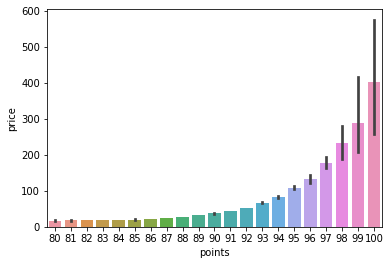

In [9]:
# correlation between points and price
seaborn.barplot(x = 'points', y = 'price', data = word_cloud_df)

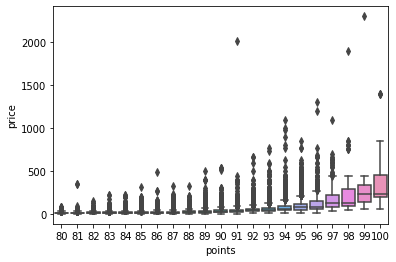

In [10]:
seaborn.boxplot(x = 'points', y = 'price', data = word_cloud_df)

It appears from the visualizations above overall price increases as points increase in this dataset between $0 to $600. However when price goes above $600 there's some anomalies where for example there's a 91 point wine thats $2000. Yet there's wine in the 92-98 point range cheaper than $2000.

Create a word cloud to visualize the description column's text. These descriptions will assist with prediction models later on.

In [11]:
# import dependencies
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt


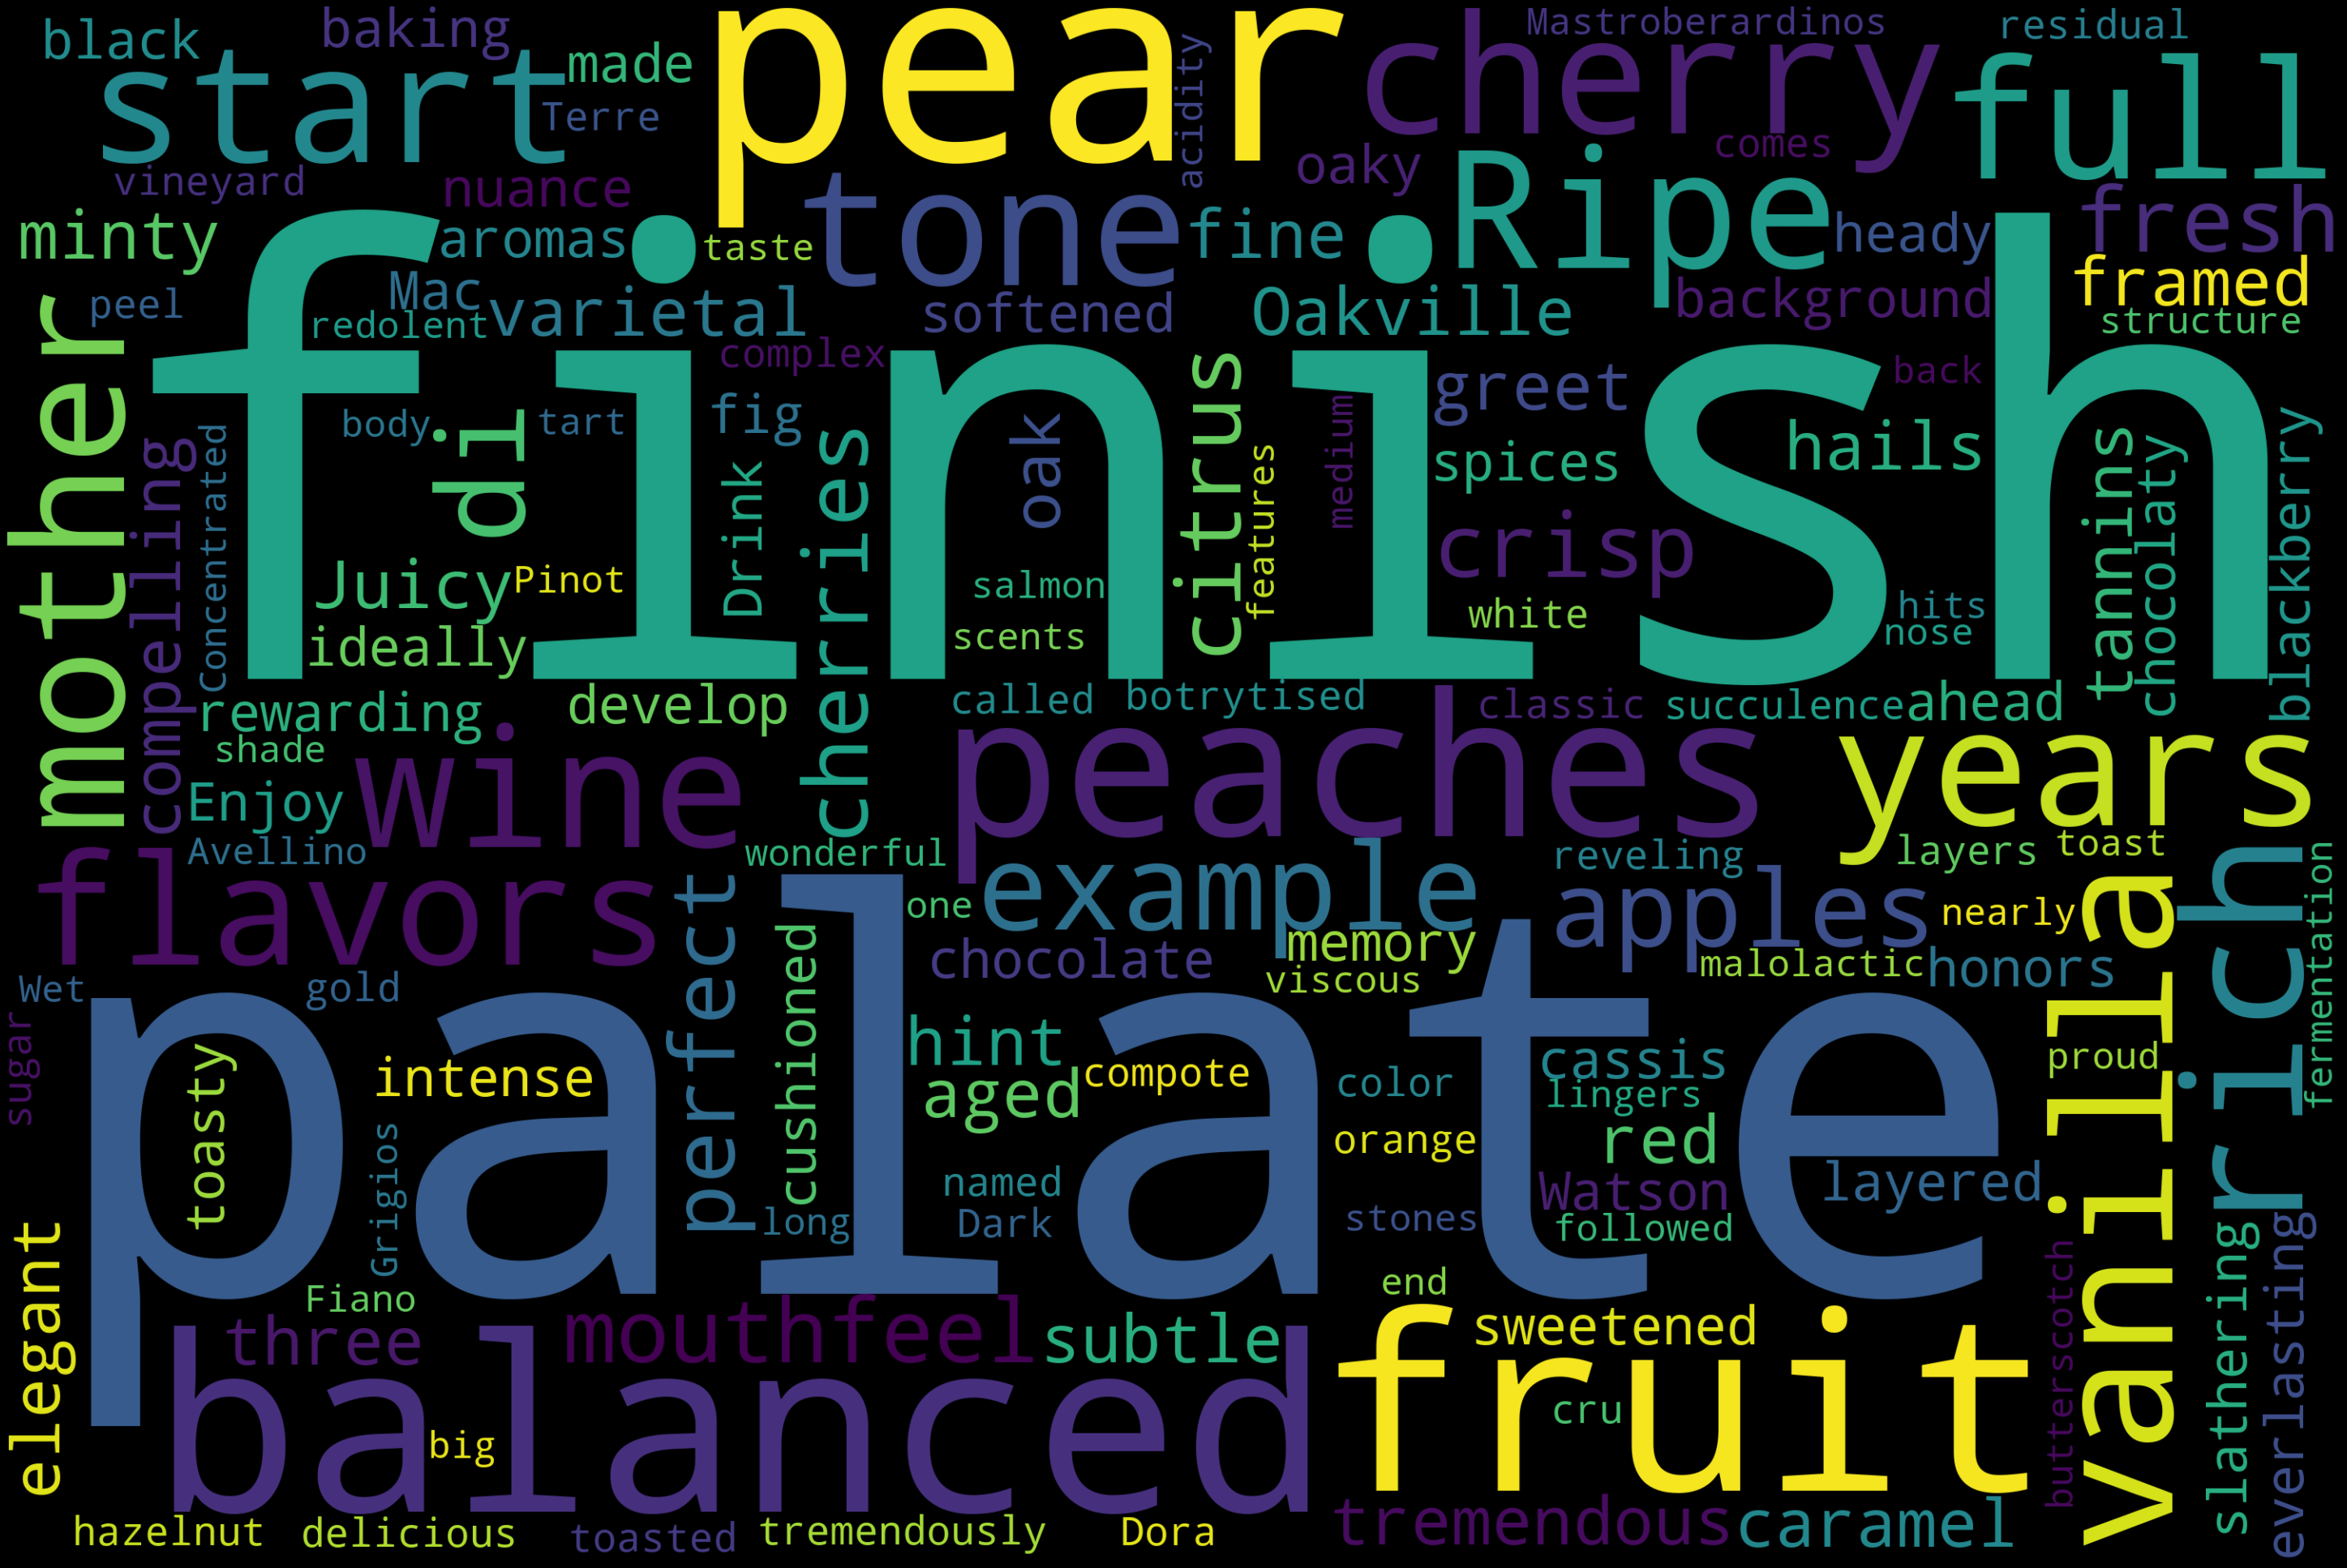

In [12]:
# couldn't get my word cloud image to show, stack overflow was helpful
text = word_cloud_df.description.values
word_cloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k',)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


Add a quality column from points of wines to create bins/classes that match the winemag wine point classifcations.

In [13]:
# Robert Parker, one of the most important wine critics of our century, developed the 100-point rating scale that has governed wine since the late 1970s. 
# Parker created the system to mirror the grading systems used in schools where an “A+” is 95 or above, an “A” is 90 or above, a “B+” is 85 and above, and so on. 
# The wine in this data set only includes 80 points or higher, since most creditable wine magazines only pubish wine scoring in these ranges. 


Scores:

•	95-100 — Superb: one of the greats

•	90-94 — Excellent: extremely well-made and highly recommended

•	85-89 — Very good: may offer outstanding value if the price is right

•	80-84 — Good: solid wine, suitable for everyday consumption


In [27]:
def getQuality(points):
  if(points <= 80):
    return 'Good'
  elif(points <= 85):
    return 'Very good'
  elif(points <= 90):
    return 'Excellent'
  elif(points <= 95):
    return 'Superb'
  else:
    return 'Mediocre(=< 79)'
    # return 'Unfortunately something went wrong, please try again'

In [28]:
# apply this loop to the points column and add the 'quality' column
word_cloud_df['quality'] = word_cloud_df['points'].apply(getQuality)
word_cloud_df

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,quality,priceRange
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,Mediocre(=< 79),$201-$300
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,Mediocre(=< 79),$101-$200
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,Mediocre(=< 79),$76-$100
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,Mediocre(=< 79),$51-$75
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,Superb,$51-$75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150925,150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio,Superb,$1-$25
150926,150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain,Superb,$26-$50
150927,150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora,Superb,$1-$25
150928,150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset,Excellent,$51-$75


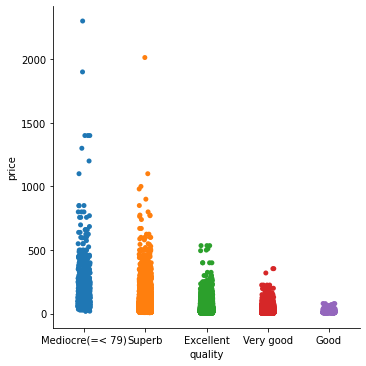

In [29]:
seaborn.catplot(x = 'quality', y = 'price', data = word_cloud_df)

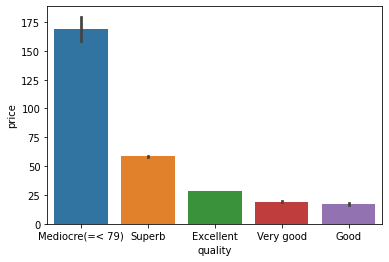

In [30]:
seaborn.barplot(x = 'quality', y = 'price', data = word_cloud_df)


In [31]:
def getPriceRange(price):
  if (price <= 25):
    return '$1-$25'
  if (price <= 50):
    return '$26-$50'
  if (price <= 75):
    return '$51-$75'
  if (price <= 100):
    return '$76-$100'
  if (price <= 200):
    return '$101-$200'
  if (price <= 300):
    return '$201-$300'
  if (price <= 400):
    return '$301-$400'
  if (price <= 500):
    return '$401-$500'
  if (price <= 1000):
    return '$501-$1000'
  if (price <= 1500):
    return '$1001-$1500'
  elif (math.isnan(price)):
    return '$0'
  else:
    return 'Above $1500'
  
    

In [32]:
word_cloud_df['priceRange'] = word_cloud_df['price'].apply(getPriceRange)

In [33]:
word_cloud_df.groupby(word_cloud_df['priceRange']).size()


priceRange
$0             13695
$1-$25         75175
$1001-$1500        7
$101-$200       2690
$201-$300        467
$26-$50        42643
$301-$400        154
$401-$500         81
$501-$1000        63
$51-$75        11786
$76-$100        4166
Above $1500        3
dtype: int64